In [34]:
from commonfunctions import *
import cv2
import imutils
from skimage.transform import hough_line, hough_line_peaks
from scipy.stats import mode


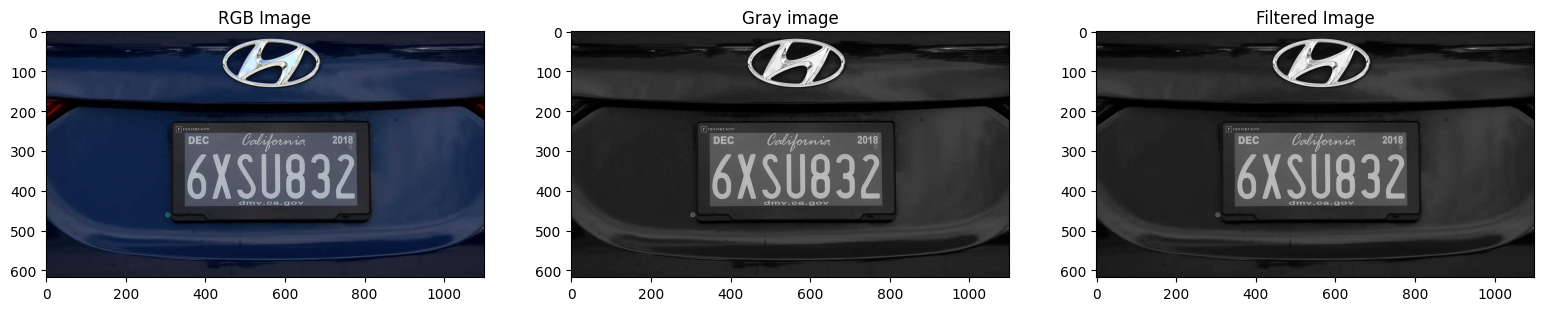

In [35]:
def preprocess_image(img):
    gray_img = rgb2gray(img)
    gray_img = (gray_img*255).astype(np.uint8)    
    filtered_img = cv2.bilateralFilter(gray_img, 5, 20, 100, borderType=cv2.BORDER_CONSTANT)
    return filtered_img



img = io.imread('imgs/License1.jpg')
show_images([img,rgb2gray(img),preprocess_image(img)],titles=['RGB Image','Gray image','Filtered Image'])

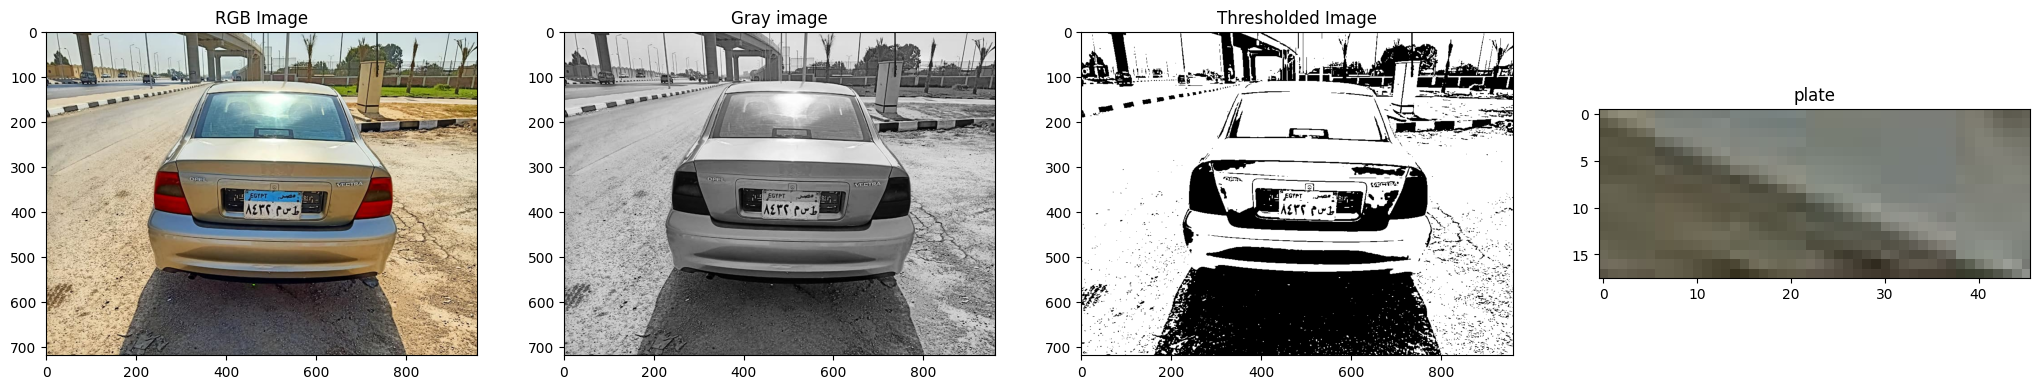

In [36]:
import cv2

img = io.imread('imgs/0006.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img = (gray).astype(np.uint8)
filtered_img = cv2.bilateralFilter(gray_img, 5, 20, 100, borderType=cv2.BORDER_CONSTANT)



# Perform thresholding or other preprocessing steps as needed to isolate the plate
# For example, you can use adaptive thresholding
# thresh = cv2.adaptiveThreshold(filtered_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
_, mask = cv2.threshold(filtered_img, 100, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plate = None
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    area = cv2.contourArea(contour)
    if (aspect_ratio > 2.5) and (aspect_ratio < 3.5):
        filtered_contours.append(contour)

if filtered_contours:
    max_contour = max(filtered_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    plate = img[y:y + h, x:x + w]




show_images([img,gray,mask,plate],titles=['RGB Image','Gray image','Thresholded Image','plate'])


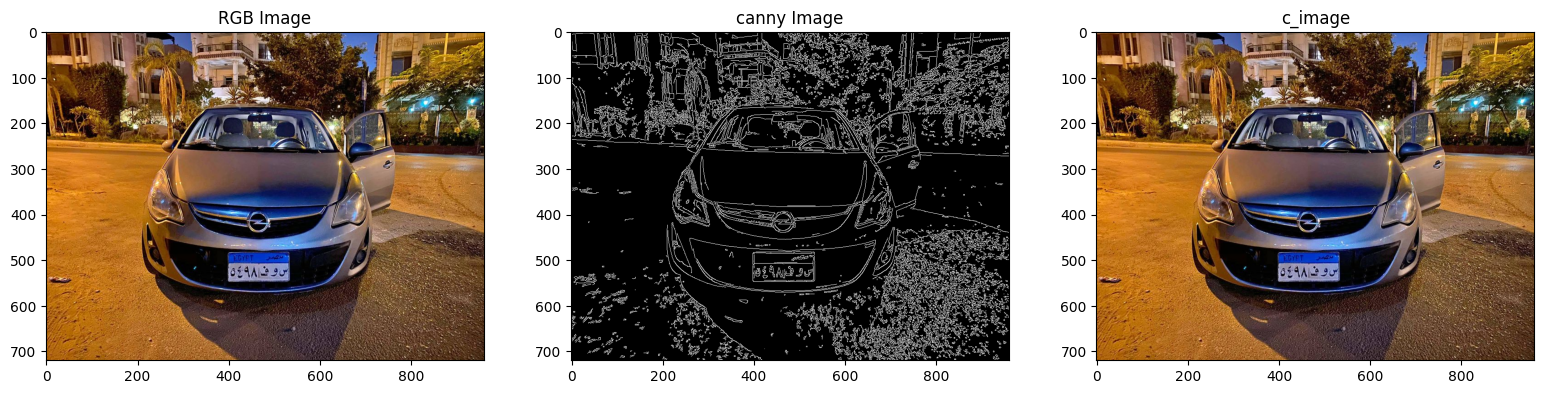

In [37]:
image = io.imread('imgs/0016.jpg')
c_image = image.copy()
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filtered_img = cv2.bilateralFilter(img_gray, 11, 20, 17)

img_canny = cv2.Canny(filtered_img, 70, 200)

# kernel = np.ones((3,3))
# img_dil = cv2.dilate(img_canny, kernel, iterations=2) 
points = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = imutils.grab_contours(points)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:80] 
# cv2.drawContours(c_image, contours, -1, (0, 255, 0), 2)

filtered_contours = []
for contour in contours:
   approx = cv2.approxPolyDP(contour, 60, True)
   if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        if (aspect_ratio > 2.5) and (aspect_ratio < 3.5) and (area < 500):
            filtered_contours.append(contour)

if filtered_contours:
    max_contour = max(filtered_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    cv2.rectangle(c_image, (x, y), (x + w, y + h), (0, 255, 0), 2)            


       

show_images([image,img_canny, c_image],titles=['RGB Image','canny Image','c_image'])   


21
1.8448275862068966

area  4420.5
1.0136986301369864
1.4489795918367347
0.8656716417910447
0.8444444444444444
1.0357142857142858
0.967741935483871
1.037037037037037
0.9333333333333333
0.37037037037037035
0.9523809523809523
0.7333333333333333
3.142857142857143

area  50.0
5.8
0.5
1.25
0.18181818181818182
0.3333333333333333
1.0
1.0
3.0

area  0.0


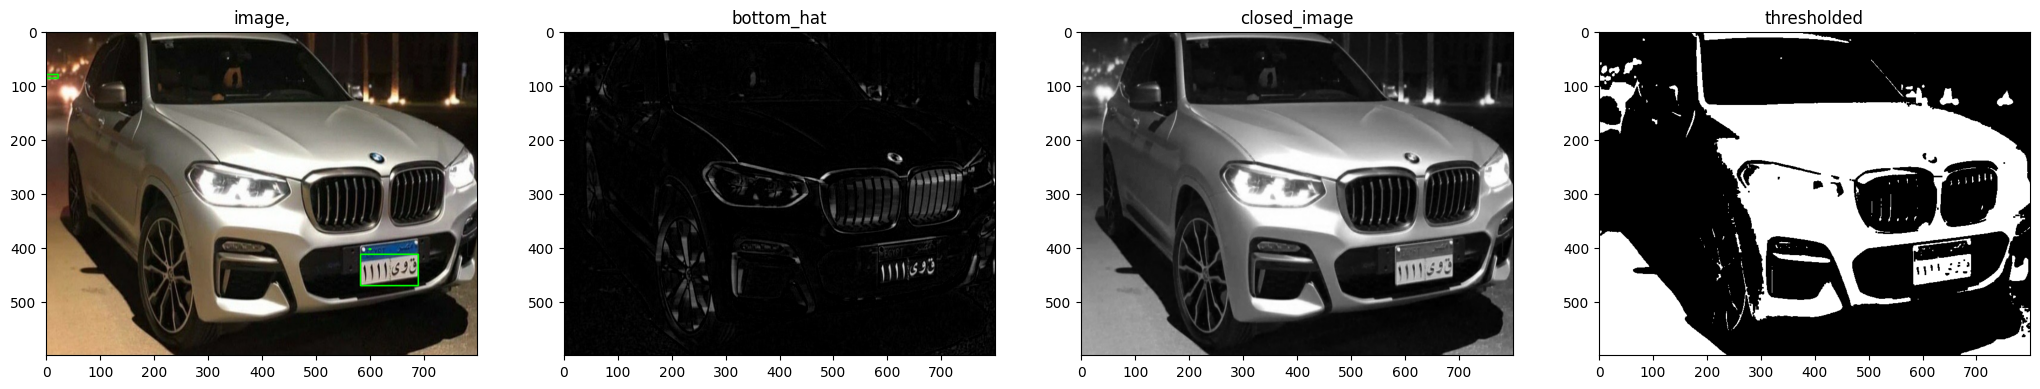

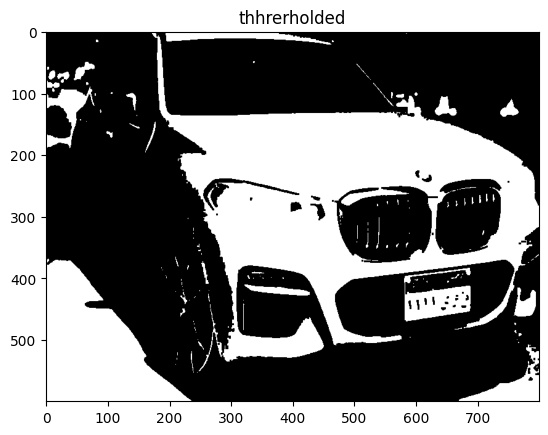

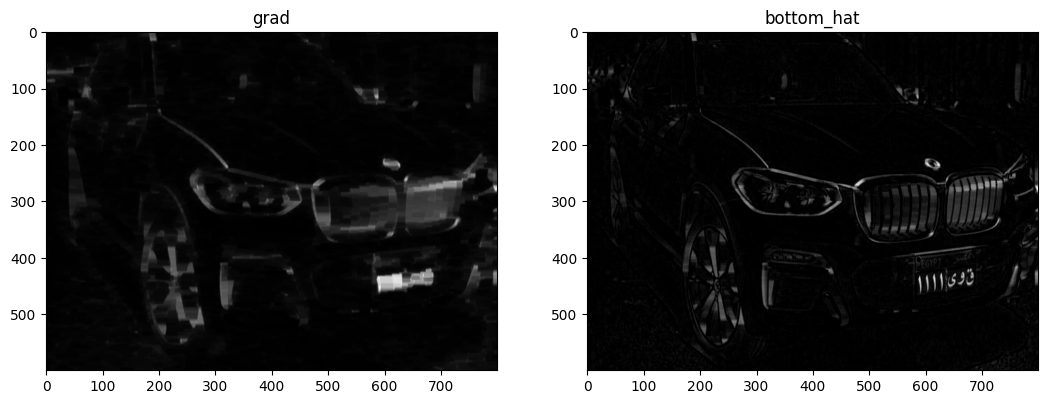

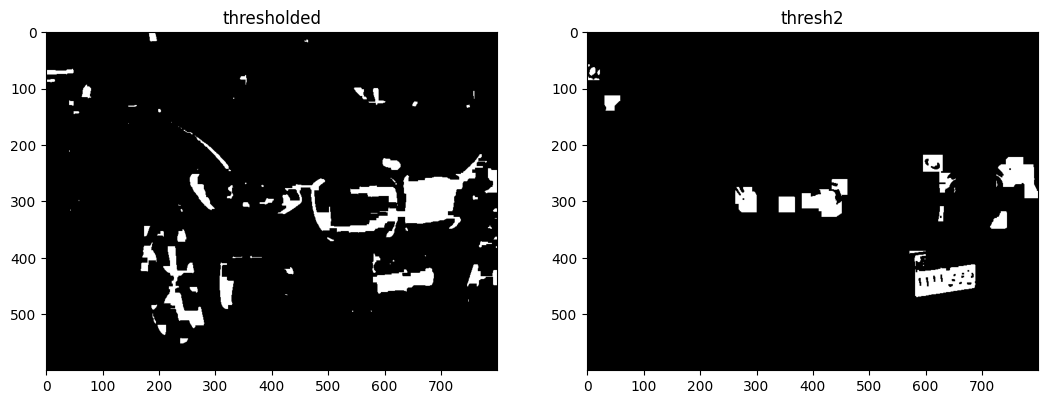

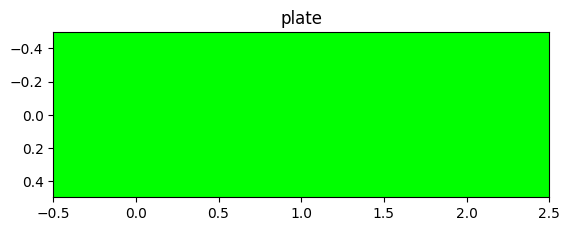

In [103]:
import cv2
from commonfunctions import *


# pipeline  (still needs some enhancements)
# 1- convert to gray
# 2- apply bottom hat
# 3- apply adaptive thresholding
# 4- apply opening
# 5- apply connected components
# 6- filter components by area
# 7- apply closing

image = io.imread('imgs/0041.jpg')
image = cv2.resize(image,(800,600))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#kernel sizes
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
kernel_closing = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
kernel_opening = np.ones((3, 3), np.uint8)


bottom_hat = cv2.morphologyEx(image_gray, cv2.MORPH_BLACKHAT, kernel_rect) # search for blackhat morphological operation

closed_image = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel_closing)

thresholded = cv2.threshold(closed_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # search for adpative thresholding (otsu's)
# opened_image = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel_opening)

# apply sobel to detect vertical edges and then normalize gradients to range from 0 to 255
gradX = cv2.Sobel(bottom_hat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")

# #contours 
gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, kernel_rect)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# num_labels, labels = cv2.connectedComponents(opened_image)
# #print(labels)   
thresh2 = cv2.bitwise_and(thresh, thresh, mask=thresholded)
thresh2 = cv2.erode(thresh2, None, iterations=3)
thresh2 = cv2.dilate(thresh2, None, iterations=8)
thresh2 = cv2.erode(thresh2, None, iterations=1)
thresh2 = cv2.dilate(thresh2, None, iterations=7)
thresh2 = cv2.erode(thresh2, None, iterations=1)

thresh2 = cv2.bitwise_and(thresh2,thresh2,mask=thresholded)

# # erosed_image = cv2.erode(thresholded, kernel_square, iterations=1) 
# # opened_image = cv2.morphologyEx(erosed_image, cv2.MORPH_OPEN, kernel_rect)

contours = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

print(contours.__len__())
plate = None

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    ar = w / float(h)
    print(ar)

    if w > 300 or h > 140:
        continue    

    if w > 1.5*h and w < 3.5*h:
        print()
        print("area ",area)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plate = image[y:y + h, x:x + w]



# closed_image = cv2.morphologyEx(labels.astype(np.uint8), cv2.MORPH_CLOSE, kernel_closing)


# edges = cv2.Canny(closed_image, 100, 200)
# contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



# filtered_contours = []
# plate = None
# #filter contours by aspect ratio and area
# for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     aspect_ratio = float(w) / h
#     area = cv2.contourArea(contour)
#     if area > 500 and area < 5000:
#         filtered_contours.append(contour)




    
    

show_images([image,bottom_hat,closed_image,thresholded],titles=['image,','bottom_hat','closed_image','thresholded'])
show_images([thresholded],titles=['thhrerholded'])
show_images([gradX,bottom_hat],titles=['grad','bottom_hat'])
show_images([thresh,thresh2],titles=['thresholded','thresh2'])
show_images([plate],titles=['plate'])
# show_images([closed_image],titles=['closed_image'])

